In [1]:
import random
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import f
from scipy.stats import chi2
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import docx
%matplotlib inline

In [2]:
class distr:
    def __init__(self, random_state, name, n, *args):
        self.name = name
        self.args = args
        self.n = n
        
        if name == 'norm':
            self.data = stats.norm.rvs(args[0], args[1], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[1]**2
            self.r_std = args[1]
            
        if name == 'chi2':
            self.data = stats.chi2.rvs(args[0], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[0]*2
            self.r_std = np.sqrt(args[0]*2)
            
        if name == 'r':
            self.data = stats.uniform(loc = args[0], scale = args[1] - args[0]).rvs(size = n, random_state = random_state)
            self.r_mean = (args[0] + args[1])/2.
            self.r_var = (args[1] - args[0])**2/12.
            self.r_std = np.sqrt((args[1] - args[0])**2/12.)
            
        self.s_mean = self.data.mean()
        self.s_var = self.data.var()
        self.s_std = self.data.std()
        
        
    def __str__(self):
        return str(self.name) + ' ' + str(self.args) + ' ' + str(self.n) + \
                ' sample_mean=' + str(round(self.s_mean, 2)) + ' sample_var=' + str(round(self.s_var, 2))
    
    def z_test(self, m0):
        z = (self.s_mean - m0)/(self.r_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.norm.cdf(abs(z)))
        return (z, p_val)
    
    def t_test(self, m0):
        z = (self.s_mean - m0)/(self.s_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.t.cdf(abs(z), self.n - 1))
        return (z, p_val)
    
    def chi2_test0(self, v0):
        z = np.sum((self.data - self.r_mean)**2)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n), stats.chi2.cdf(z, self.n))
        return (z, p_val)
    
    def chi2_test1(self, v0):
        z = self.s_var*(self.n - 1)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n - 1), stats.chi2.cdf(z, self.n - 1))
        return (z, p_val)

In [3]:
def disp_analyses_tabl(*args):
    tabl = np.zeros((3, 3))
    k = len(args) #num_of_groups
    n = sum([len(args[i]) for i in range(k)])# general num of el
    full_sample = np.concatenate([args[i] for i in range(k)], axis = 0)
    n_i = [len(args[i]) for i in range(k)]
    v_i = [np.var(args[i]) for i in range(k)]
    m_i = [np.mean(args[i]) for i in range(k)]
    m = np.mean(full_sample)
    d_vn_gr = np.average(v_i, weights=n_i)
    tabl[1][0] = d_vn_gr
    tabl[1][1] = n - k
    tabl[1][2] = d_vn_gr*(n/(n-k))
    d_ob = np.var(full_sample)
    tabl[2][0] = d_ob
    tabl[2][1] = n - 1
    tabl[2][2] = d_ob*(n/(n-1))
    d_m_gr = np.average(np.array([m_i[i] - m for i in range(k)])**2, weights=n_i)
    tabl[0][0] = d_m_gr
    tabl[0][1] = k - 1
    tabl[0][2] = d_m_gr*(n/(k-1))
    return tabl

In [4]:
def pooled_mean(args):
    res = sum([len(args[i])*np.mean(args[i]) for i in range(len(args))])/sum([len(args[i]) for i in range(len(args))])
    return res
def pooled_var(args):
    res = sum([(len(args[i])-1)*np.var(args[i]) for i in range(len(args))])/sum([(len(args[i])-1) for i in range(len(args))])
    return res

In [5]:
def task_1(doc, dist_arr, alpha):
    
    for i in range(len(dist_arr)):
        doc.tables[0].rows[i+1].cells[1].text  = dist_arr[i].name 
        doc.tables[0].rows[i+1].cells[5].text  = str(dist_arr[i].n) 
        
        if dist_arr[i].name == 'norm':
            doc.tables[0].rows[i+1].cells[2].text  = 'm='+str(dist_arr[i].args[0])+'\nstd='+str(dist_arr[i].args[1])
            doc.tables[0].rows[i+1].cells[3].text  = str(dist_arr[i].args[0])
            doc.tables[0].rows[i+1].cells[4].text  = str(round(dist_arr[i].args[1]**2))
        
        if dist_arr[i].name == 'chi2':
            doc.tables[0].rows[i+1].cells[2].text  = 'число ст. своб='+str(dist_arr[i].args[0])
            doc.tables[0].rows[i+1].cells[3].text  = str(dist_arr[i].args[0])
            doc.tables[0].rows[i+1].cells[4].text  = str(round(dist_arr[i].args[0]*2))
        
        if dist_arr[i].name == 'r':
            doc.tables[0].rows[i+1].cells[2].text  = 'a='+str(dist_arr[i].args[0])+'\nb='+str(dist_arr[i].args[1])
            doc.tables[0].rows[i+1].cells[3].text  = str(round((dist_arr[i].args[0] + dist_arr[i].args[1])/2., 2))
            doc.tables[0].rows[i+1].cells[4].text  = str(round((dist_arr[i].args[1] - dist_arr[i].args[0])**2/12., 2))
            
    for i in range(len(dist_arr)):
        doc.tables[1].rows[i+1].cells[1].text = str(round(dist_arr[i].s_mean, 2))
        doc.tables[1].rows[i+1].cells[2].text = str(round(dist_arr[i].s_var, 2))
        doc.tables[1].rows[i+1].cells[3].text = str(round(dist_arr[i].s_var**(0.5), 2))
        
    doc.tables[1].rows[6].cells[1].text = str(round(pooled_mean([dist_arr[i].data for i in range(len(dist_arr))]), 2))
    doc.tables[1].rows[6].cells[2].text = str(round(pooled_var([dist_arr[i].data for i in range(len(dist_arr))]), 2))
    doc.tables[1].rows[6].cells[3].text = str(round(np.sqrt(pooled_var([dist_arr[i].data for i in range(len(dist_arr))])), 2))
    
    z1 = stats.bartlett(*[dist_arr[i].data for i in range(len(dist_arr))])
    
    doc.tables[2].rows[1].cells[0].text = str(round(z1[0], 3))
    doc.tables[2].rows[1].cells[1].text = "{:.3e}".format(z1[1])
    
    if z1[1] < alpha:  
        doc.tables[2].rows[1].cells[2].text = 'H0 отверг'
        
        if sum([dist_arr[i+1].r_var == dist_arr[i].r_var for i in range(len(dist_arr)-1)]) == len(dist_arr)-1:
            doc.tables[2].rows[1].cells[3].text = 'Ош. 1го рода'
        else:
            doc.tables[2].rows[1].cells[3].text = 'Нет ош.'
    else:
        doc.tables[2].rows[1].cells[2].text = 'H0 приним'
        if sum([dist_arr[i+1].r_var == dist_arr[i].r_var for i in range(len(dist_arr)-1)]) == len(dist_arr)-1:
            doc.tables[2].rows[1].cells[3].text = 'Нет ош.'
        else:
            doc.tables[2].rows[1].cells[3].text = 'Ош. 2го рода'
            
    z1 = stats.f_oneway(*[dist_arr[i].data for i in range(len(dist_arr))])
    
    doc.tables[4].rows[1].cells[0].text = str(round(z1[0], 3))
    doc.tables[4].rows[1].cells[1].text = "{:.3e}".format(z1[1])
    
    if z1[1] < alpha:  
        doc.tables[4].rows[1].cells[2].text = 'H0 отверг'
        if sum([dist_arr[i+1].r_mean == dist_arr[i].r_mean for i in range(len(dist_arr)-1)]) == len(dist_arr)-1:
            doc.tables[4].rows[1].cells[3].text = 'Ош. 1го рода'
        else:
            doc.tables[4].rows[1].cells[3].text = 'Нет ош.'
    else:
        doc.tables[4].rows[1].cells[2].text = 'H0 приним'
        if sum([dist_arr[i+1].r_mean == dist_arr[i].r_mean for i in range(len(dist_arr)-1)]) == len(dist_arr)-1:
            doc.tables[4].rows[1].cells[3].text = 'Нет ош.'
        else:
            doc.tables[4].rows[1].cells[3].text = 'Ош. 2го рода'
    
    

In [6]:
def task_2(doc, dist_arr):
    tabl = disp_analyses_tabl(*[dist_arr[i].data for i in range(len(dist_arr))])
    for i in range(tabl.shape[0]):
        for j in range(tabl.shape[1]):
            doc.tables[3].rows[i+1].cells[j+1].text = str(round(tabl[i][j], 3))
            
    theta2 = tabl[0][0]/tabl[2][0]
    theta = np.sqrt(theta2)
    doc.paragraphs[44].text = u'Эмпирический коэффициент детерминации  = ' + str(round(theta2, 3))
    doc.paragraphs[46].text = u'Эмпирическое корреляционное отношение  = ' + str(round(theta, 3))

In [7]:
def graphics(dist_arr):
    fig, ax = plt.subplots(1, 1)
    ax.boxplot([dist_arr[i].data for i in range(len(dist_arr))])
    plt.savefig('lab3_im/lab3_1.png')
    
    our_df = pd.DataFrame(np.concatenate([dist_arr[i].data for i in range(len(dist_arr))],axis=0), columns=['data'])
    our_labels = []
    for i in range(len(dist_arr)):
        our_labels += dist_arr[i].n*[i]
    our_df['label'] = our_labels
    
    res = pairwise_tukeyhsd(our_df['data'], our_df['label'])
    mod = MultiComparison(our_df['data'], our_df['label'])
    
    pair_labels = []
    for i in range(len(res.groupsunique)-1):
        for j in range(len(res.groupsunique)):
            if i<j:
                pair_labels.append((res.groupsunique[i]+1, res.groupsunique[j]+1))
    
    fig, ax = plt.subplots(1, 1)
    plt.plot(list(range(len(pair_labels))), res.meandiffs, 'o')
    plt.errorbar(list(range(len(pair_labels))), res.meandiffs, yerr=np.abs(res.confint[:,1] - res.confint[:,0]), fmt = 'o')
    xlim = -0.5, 5.5
    plt.hlines(0, *xlim)
    plt.xlim(*xlim)
    plt.xticks(list(range(len(pair_labels))), pair_labels)
    plt.title('Multiple Comparisons between all pairs of means')
    plt.savefig('lab3_im/lab3_2.png')

In [8]:
def task_3(doc, dist_arr, alpha):
    pair_labels = []
    for i in range(len(dist_arr)-1):
        for j in range(i+1, len(dist_arr)):
            if i<j:
                pair_labels.append((i, j))
                
    for i in range(len(pair_labels)):
        z1 = stats.ttest_ind(dist_arr[pair_labels[i][0]].data, dist_arr[pair_labels[i][1]].data)
        doc.tables[5].rows[i+1].cells[0].text = 'm'+str(pair_labels[i][0]+1)+'='+'m'+str(pair_labels[i][1]+1)
        doc.tables[5].rows[i+1].cells[1].text = str(round(z1[0],3))
        doc.tables[5].rows[i+1].cells[2].text = "{:.3e}".format(z1[1])
        
        if z1[1] < alpha:  
            doc.tables[5].rows[i+1].cells[3].text = 'H0 отверг'
        
            if dist_arr[pair_labels[i][0]].r_mean == dist_arr[pair_labels[i][1]].r_mean:
                doc.tables[5].rows[i+1].cells[4].text = 'Ош. 1го рода'
            else:
                doc.tables[5].rows[i+1].cells[4].text = 'Нет ош.'
        else:
            doc.tables[5].rows[i+1].cells[3].text = 'H0 приним'
            if dist_arr[pair_labels[i][0]].r_mean == dist_arr[pair_labels[i][1]].r_mean:
                doc.tables[5].rows[i+1].cells[4].text = 'Нет ош.'
            else:
                doc.tables[5].rows[i+1].cells[4].text = 'Ош. 2го рода'

In [9]:
doc = docx.Document('ms_otchet3.docx')
d_1 = distr(504, 'norm', 100, 1, 2)
d_2 = distr(505, 'r', 150, 0, 2)
d_3 = distr(506, 'norm', 200, 1, 3)
print(d_1, d_2, d_3, sep = '\n')

norm (1, 2) 100 sample_mean=1.33 sample_var=3.88
r (0, 2) 150 sample_mean=1.01 sample_var=0.33
norm (1, 3) 200 sample_mean=1.14 sample_var=8.28


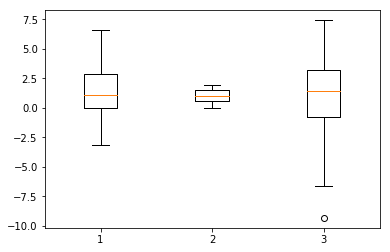

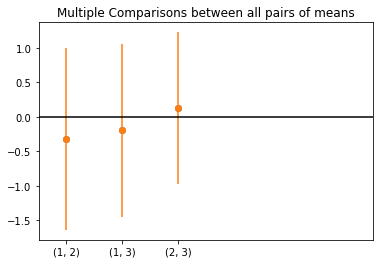

In [10]:
task_1(doc, [d_1, d_2, d_3], 0.05)
task_2(doc, [d_1, d_2, d_3])
task_3(doc, [d_1, d_2, d_3], 0.05)
graphics([d_1, d_2, d_3])

In [11]:
doc.save('lab3_kat.docx')

In [10]:
doc = docx.Document('ms_otchet3.docx')
d_1 = distr(543, 'r', 100, 2, 6)
d_2 = distr(523, 'r', 250, 2, 6)
d_3 = distr(553, 'r', 100, 0, 8)
d_4 = distr(553, 'norm', 100, 4, 1)
print(d_1, d_2, d_3, d_4, sep = '\n')

r (2, 6) 100 sample_mean=4.0 sample_var=1.26
r (2, 6) 250 sample_mean=3.94 sample_var=1.35
r (0, 8) 100 sample_mean=4.1 sample_var=5.4
norm (4, 1) 100 sample_mean=4.12 sample_var=0.94


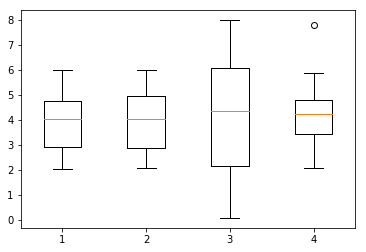

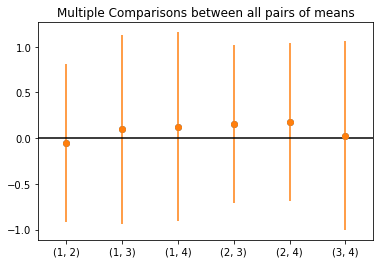

In [11]:
task_1(doc, [d_1, d_2, d_3, d_4], 0.05)
task_2(doc, [d_1, d_2, d_3, d_4])
task_3(doc, [d_1, d_2, d_3, d_4], 0.05)
graphics([d_1, d_2, d_3, d_4])

In [12]:
doc.save('lab3_nik.docx')